### Overview

In this project, we will explore whether or not the votes regression model's mean squared error will be reduced if we add topic features into regression models. The goal of this project is to improve votes regression V1.1 model and hopefully productize it.

To stage the prototype process, this notebook will be responsible for topic modeling version 1.0. We will use unsupervised learning techniques to extract topic features from movies' plot summaries. Because of the nature of unsupervised learning, it's very hard to come up with a score to measure topic modeling performance. So we will validate the model by comparing model's lable / topic to each movie's key words.

### Contents

1. Load Data
2. Preprocess / Clean Text, Tokenization, Lemmetization/Stemming
3. TF-IDF vectorization
4. K-means clustering
5. LSA (Latent Sementic Analysis) + K-means clustering
6. LDA (Latent Dirichlet allocation)
7. Visualization / Intepretation / Simularity

In [1]:
# main import
import sys
import os
import json
import nltk
import numpy as np
import pandas as pd
import tabulate

# sklearn import
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity


# visualization imports
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be rem

In [2]:
!pip install text_preprocess

ERROR: Could not find a version that satisfies the requirement text_preprocess (from versions: none)
ERROR: No matching distribution found for text_preprocess


### load data

In [3]:
data = pd.read_csv("movie_info.csv") 

In [4]:
data.head(10)

,title,release year,genre,key words,plot,run time /min,number of votes,rating
0,Sharknado,2013,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,school-bus|chainsaw|psychotronic-film|hurrican...,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3
1,The Normal Heart,2014,Drama|History|Romance,gay|gay-men's-health-crisis|hiv|aids-epidemic|...,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9
2,The Sunset Limited,2011,Drama,minimal-cast|dialogue-between-two-characters|s...,"Through a chance encounter, two men of opposin...",91,26733,7.4
3,Temple Grandin,2010,Biography|Drama,cattle|animal-husbandry|livestock|autism|feedi...,"A biopic of Temple Grandin, an autistic woman ...",107,25551,8.3
4,You Don't Know Jack,2010,Biography|Drama,suicide|assisted-suicide|moral-dilemma|moralit...,A look at the life and work of doctor-assisted...,134,25404,7.6
5,Game Change,2012,Biography|Drama|History,american-politics|cell-phone|down-syndrome|pre...,Governor Sarah Palin of Alaska becomes Senator...,118,20092,7.4
6,Princess Protection Program,2009,Comedy|Drama|Family,princess|dictator|teenager|protection|louisian...,A princess whose country has been invaded goes...,90,20083,5.6
7,Mean Girls 2,2011,Comedy,sexiness|dream-girl|short-skirt|miniskirt|teen...,The Plastics are back in the long-awaited foll...,96,19579,4.1
8,The Wizard of Lies,2017,Biography|Crime|Drama,financial-fraud|financier|ponzi-scheme|fraudst...,"The fall of Bernie Madoff, whose Ponzi scheme ...",133,19471,6.8
9,Sharknado 2: The Second One,2014,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,second-part|john-f.-kennedy-international-airp...,Fin and April are on their way to New York Cit...,95,17067,4.0


### Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root.

In [5]:
def tokenization(text):
    # tokenize
    tokens = nltk.RegexpTokenizer(pattern=r"(?u)\b\w\w+\b").tokenize(text)
    # remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    return [t for t in tokens if t.lower() not in stopwords]

def tokenization_and_stemming(text):
    # tokenize and remove stopwords
    tokens = tokenization(text)
    # stem
    porter = nltk.PorterStemmer()
    stems = [porter.stem(t) for t in tokens]
    return stems

Take a look at the first movie plots after tokenization and stemming

In [6]:
tokenization_and_stemming(data['plot'][0])

['freak',
 'hurrican',
 'swamp',
 'lo',
 'angel',
 'natur',
 'deadliest',
 'killer',
 'rule',
 'sea',
 'land',
 'air',
 'thousand',
 'shark',
 'terror',
 'waterlog',
 'populac']

In [7]:
# get list of stems and list of original tokens
stems_list = []
tokens_list = []
for d in data['plot']:
    stems = tokenization_and_stemming(d)
    stems_list.extend(stems)
    tokens = tokenization(d)
    tokens_list.extend(tokens)

# get a mapping
stem_to_word_dict = {stems_list[x]: tokens_list[x] for x in range(len(stems_list))}

In [8]:
print('total size of the vocabulary from all movies:', len(stem_to_word_dict.keys()))

total size of the vocabulary from all movies: 13186


### TF-IDF

use sklearn implementation with our own tokenizer

In [9]:
# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    min_df=2, # words with low document frequency usually are rare words like person's name, or rare entity name
    max_df=0.95, # words with high document frequency usually are common words like 'is', 'are', 'yes', 'what', ..
    max_features=10000, # we only include top 10000 words with highest tf-idf weights out of 116392
    stop_words='english',
    use_idf=True,
    tokenizer=tokenization_and_stemming, # our customized tokenizer
    ngram_range=(1,1) # not considering bi-gram
)

# get tf-idf features
tfidf_matrix = tfidf_vectorizer.fit_transform(data['plot'])
# get all selected words
tfidf_selected_words = tfidf_vectorizer.get_feature_names()
# print
tfidf_matrix.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3167, 6406)

### K-means clustering

1. look for the elbow to determine the optimal number of clusters
2. check the number of samples per group to confirm we have balanced samples accross k-means groups
3. calculate votes aggregate stats (eg. mean, ...) group by k-means group to check whether there are regression signals
4. print top n important features (words) from every group's centroid and some movies' titles to verify whether the grouping actually makes sense
5. use PCA / T-SNE to visualize k-means grouping effect

**1. look for the elbow to determine the optimal number of clusters**

In [10]:
# init potential n_clusters
n_clusters_list = list(range(1, 60, 1))
# init scores
scores = []
# init models for cache
kms = {}
for n_clusters in n_clusters_list:
    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=99
    ).fit(tfidf_matrix)
    # save models
    kms.update({n_clusters: km})
    # save score
    scores.append(-1 * km.score(tfidf_matrix))

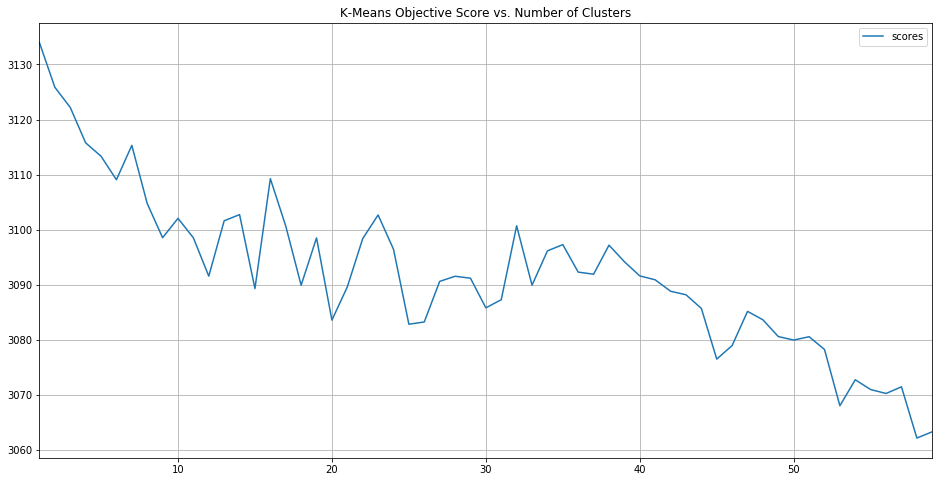

In [11]:
# look for elbow to determine optimal number of clusters
pd.DataFrame({'scores': scores}, index=n_clusters_list).plot(
    figsize=(16, 8),
    title='K-Means Objective Score vs. Number of Clusters',
    grid=True
)

In [12]:
# pick optimal K-means Model
n = 15
km = kms[n]
clusters = km.labels_.tolist()

# create DataFrame df_clusters for clustering analysis
data_clusters = {
    'title': data.title.values,
    'plot': data['plot'].values,
    'run time': data['run time /min'].values,
    'votes': data['number of votes'].values,
    'rating':data.rating.values,
    'cluster': clusters
}
df_clusters = pd.DataFrame(
    data_clusters,
    index=[clusters],
    columns=['title','plot','run time', 'votes','rating', 'cluster']
)

df_clusters.head(3)

,title,plot,run time,votes,rating,cluster
7,Sharknado,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3,7
9,The Normal Heart,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9,9
9,The Sunset Limited,"Through a chance encounter, two men of opposin...",91,26733,7.4,9


**2. check the number of samples per group to confirm we have balanced samples accross k-means groups**

In [13]:
print("Number of movies included in each cluster:")
df_clusters['cluster'].value_counts().to_frame()

Number of movies included in each cluster:


,cluster
9,1923
1,556
10,175
5,110
2,102
0,79
4,74
7,32
13,29
6,29


**3. calculate votes aggregate stats (eg. mean, ...) group by k-means cluster to check whether there are regression signals**

In [14]:
print("High level aggregate statistics of 'votes' per cluster:")
df_clusters.groupby('cluster')['votes'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'votes' per cluster:


,mean,median,max,min,count
cluster,,,,,
0,516.784810,82.0,8539,9,79
1,598.557554,182.0,16375,9,556
2,506.196078,108.0,12563,9,102
3,1427.611111,270.0,15023,10,18
4,367.729730,102.5,2401,9,74
5,1327.400000,476.0,13616,10,110
6,382.068966,49.0,5151,9,29
7,2811.593750,737.0,44265,10,32
8,535.055556,71.0,2534,17,18


**4. print top n important features (words) from every group's centroid and some movies' titles to verify whether the grouping actually makes sense**

In [15]:
# let take top n words
topn = 5
# get sorted weighted word index in cluster centroid
sorted_idx_centroids = km.cluster_centers_.argsort()[:, ::-1] 
# init cluster_keywords for storing key words
cluster_keywords = {}

print("<Movie plot summaries clustering result by K-means>")
for i in df_clusters.cluster.sort_values().unique():
    print('Cluster', i)
    print('number of movies:', len(df_clusters.loc[i]))
    print('average votes:', round(df_clusters.loc[i, 'votes'].mean(), 2))
    print('key words:')
    # record key words for each cluster
    cluster_keywords[i] = [stem_to_word_dict[tfidf_selected_words[idx]] for idx in sorted_idx_centroids[i, :topn]]
    print(cluster_keywords[i])
    print('sample titles:')
    print(df_clusters.loc[i]['title'].sample(n=1, replace=False).values.tolist())
    print()


<Movie plot summaries clustering result by K-means>
Cluster 0
number of movies: 79
average votes: 516.78
key words:
['Music', 'interview', 'rock', 'look', 'band']
sample titles:
['The Big Bang Theory: It All Started with a Big Bang']

Cluster 1
number of movies: 556
average votes: 598.56
key words:
['family', 'young', 'woman', 'mother', 'home']
sample titles:
['Punk']

Cluster 2
number of movies: 102
average votes: 506.2
key words:
['years', 'old', 'girl', 'story', 'son']
sample titles:
['63 Up']

Cluster 3
number of movies: 18
average votes: 1427.61
key words:
['camps', 'remembering', 'summer', 'competition', 'atmosphere']
sample titles:
['Kiss at Pine Lake']

Cluster 4
number of movies: 74
average votes: 367.73
key words:
['investigator', 'police', 'murder', 'death', 'disappear']
sample titles:
['Wolff - Kampf im Revier']

Cluster 5
number of movies: 110
average votes: 1327.4
key words:
['schools', 'high', 'new', 'girl', 'student']
sample titles:
['Z-O-M-B-I-E-S']

Cluster 6
number o

**Obervations about the votes vs. kmean clusters**
1. Medium readers tends to prefer reading blog posts with contents about people, work, content, app, users, product, blockchain topics. And blog posts with those topic are generally given more claps
2. Medium readers tends to give less claps to blog posts with content focus on data, learning, company, teams, topics

**5. PCA visualize K-means clusters**

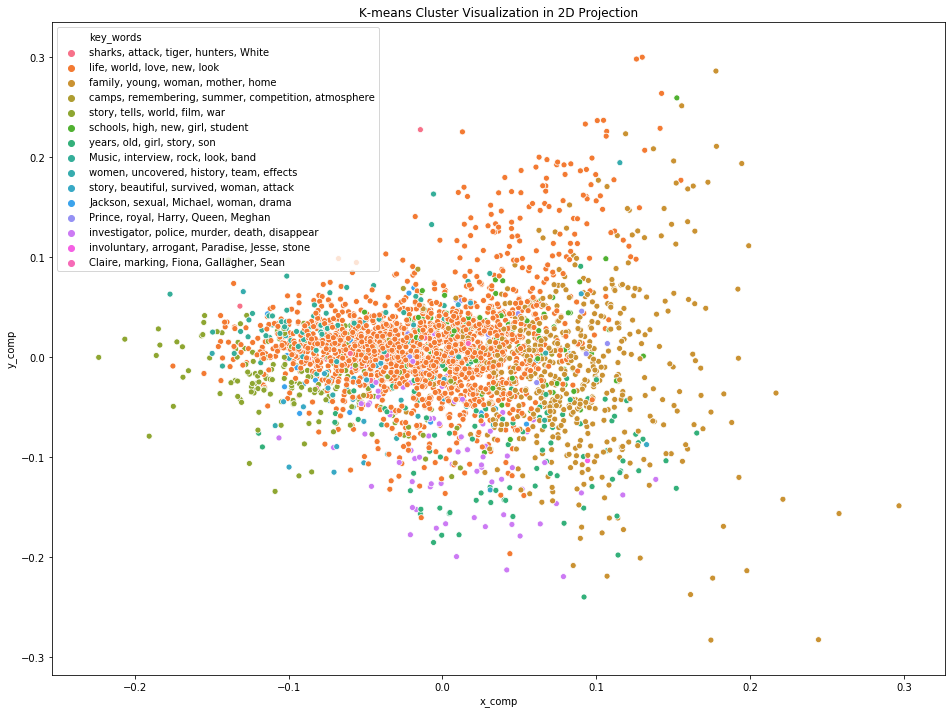

In [16]:
# train PCA
pca = PCA(n_components=2).fit(tfidf_matrix.toarray())
# get 2-D representation of our data
X_pca = pca.transform(tfidf_matrix.toarray())
# convert to dataframe for visualization
df_pca = pd.DataFrame(X_pca, columns=['x_comp', 'y_comp'])
df_pca['cluster'] = df_clusters['cluster'].copy().values
df_pca['key_words'] = df_pca.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in 2D Projection')
sns.scatterplot(
    x="x_comp",
    y="y_comp",
    hue='key_words',
    data=df_pca,
    ax=ax
)

**6. TSNE visualize K-means clusters**

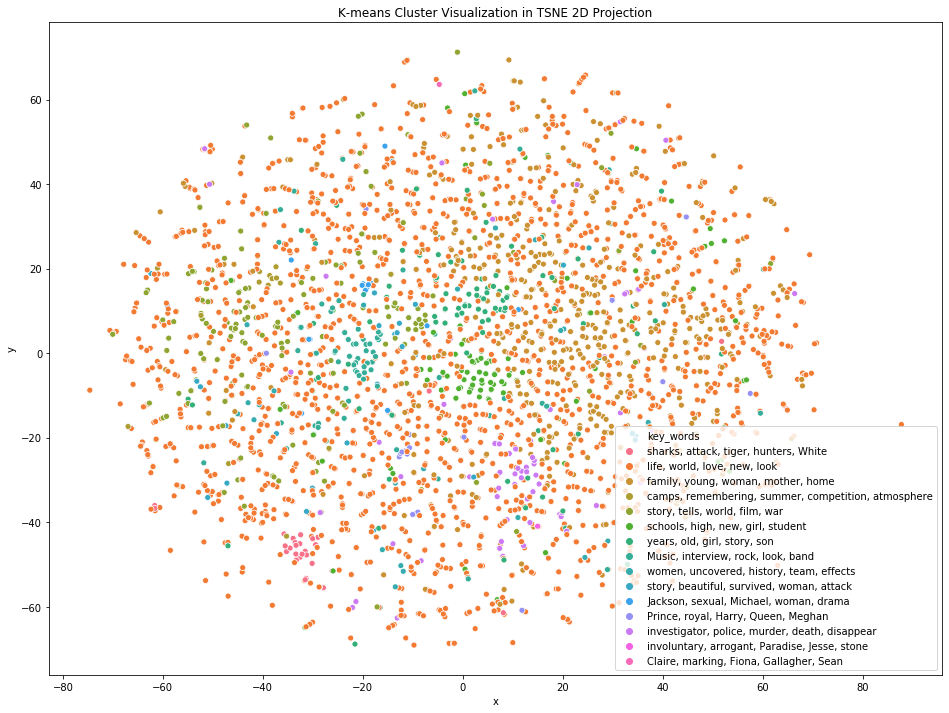

In [17]:
# get 2-D representation of our data
X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())
# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
df_tsne['cluster'] = df_clusters['cluster'].copy().values
df_tsne['key_words'] = df_tsne.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=df_tsne,
    ax=ax
)

**Obervations about k-means clustering**
1. t-SNE visualization shows much better details than PCA visualization
2. K-means does a good job on clustering big groups roughly. The left side of plot is mostly occupied by Blog posts tagged with 'Startup', the right side of the plot is mostly occupied by 'Data Science'
3. However, we can see there are a lot more clusters than we thought in these blog posts. And there are a lot of individual topic that are further away from the majority, those are out there on their individual island, as shown at the upper part of the plot
4. We can see one drawback about K-means clustering here is that, K-means clusters groups based on linear distance. However, in the data high-dimensional space, there is non-linear pattern or manifold pattern
5. Roughly speaking, excluding those individual topics, there are 30 topics

### LSA + K-means clustering

In [18]:
# LSA
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
# dimension reduction
lsa_matrix = lsa.fit_transform(tfidf_matrix)

In [19]:
# init potential n_clusters
n_clusters_list = list(range(1, 60, 1))
# init scores
scores = []
# init models for cache
kms = {}
for n_clusters in n_clusters_list:
    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=99
    ).fit(lsa_matrix)
    # save models
    kms.update({n_clusters: km})
    # save score
    scores.append(-1 * km.score(lsa_matrix))

**1. look for the optimal number of clusters for K-means grouping**

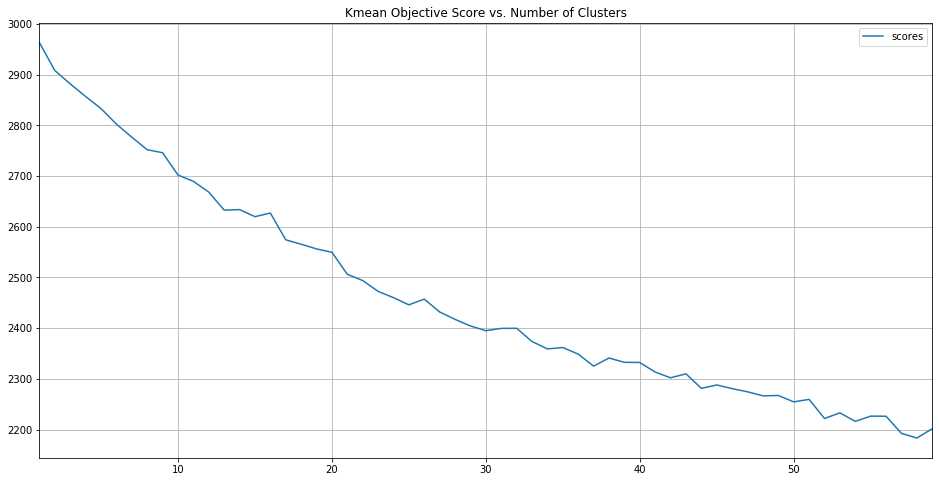

In [20]:
# look for elbow to determine optimal number of clusters
pd.DataFrame({'scores': scores}, index=n_clusters_list).plot(
    figsize=(16, 8),
    title='Kmean Objective Score vs. Number of Clusters',
    grid=True
)

In [21]:
# create DataFrame df_clusters for clustering analysis
# create DataFrame df_clusters for clustering analysis
data_clusters = {
    'title': data.title.values,
    'plot': data['plot'].values,
    'run time': data['run time /min'].values,
    'votes': data['number of votes'].values,
    'rating':data.rating.values,
    'cluster': clusters
}
df_clusters = pd.DataFrame(
    data_clusters,
    index=[clusters],
    columns=['title','plot','run time', 'votes','rating', 'cluster']
)


df_clusters.head(3)

,title,plot,run time,votes,rating,cluster
7,Sharknado,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3,7
9,The Normal Heart,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9,9
9,The Sunset Limited,"Through a chance encounter, two men of opposin...",91,26733,7.4,9


**2. calculate votes aggregate stats (eg. mean, ...) group by k-means cluster to check whether there are regression signals**

In [22]:
print("High level aggregate statistics of 'votes' per cluster:")
df_clusters.groupby('cluster')['votes'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'votes' per cluster:


,mean,median,max,min,count
cluster,,,,,
0,516.784810,82.0,8539,9,79
1,598.557554,182.0,16375,9,556
2,506.196078,108.0,12563,9,102
3,1427.611111,270.0,15023,10,18
4,367.729730,102.5,2401,9,74
5,1327.400000,476.0,13616,10,110
6,382.068966,49.0,5151,9,29
7,2811.593750,737.0,44265,10,32
8,535.055556,71.0,2534,17,18


**3. print top n important features (words) from every group's centroid and some movies' titles to verify whether the grouping actually makes sense**

In [23]:
# let take top n words
topn = 5
# get sorted weighted word index in cluster centroid
df_tfidf_cluster = pd.DataFrame(tfidf_matrix.todense())
df_tfidf_cluster['cluster'] = df_clusters.cluster.copy().values
cluster_centers = df_tfidf_cluster.groupby('cluster').mean().values
sorted_idx_centroids = cluster_centers.argsort()[:, ::-1] 
# init cluster_keywords for storing key words
cluster_keywords = {}

print("<Movie plot summaries clustering result by K-means>")
for i in df_clusters.cluster.sort_values().unique():
    print('Cluster', i)
    print('number of movies:', len(df_clusters.loc[i]))
    print('average votes:', round(df_clusters.loc[i, 'votes'].mean(), 2))
    print('key words:')
    # record key words for each cluster
    cluster_keywords[i] = [stem_to_word_dict[tfidf_selected_words[idx]] for idx in sorted_idx_centroids[i, :topn]]
    print(cluster_keywords[i])
    print('sample titles:')
    print(df_clusters.loc[i]['title'].sample(n=1, replace=False).values.tolist())
    print()

<Movie plot summaries clustering result by K-means>
Cluster 0
number of movies: 79
average votes: 516.78
key words:
['Music', 'interview', 'look', 'band', 'rock']
sample titles:
['An OMP Christmas']

Cluster 1
number of movies: 556
average votes: 598.56
key words:
['family', 'woman', 'young', 'mother', 'father']
sample titles:
['Class']

Cluster 2
number of movies: 102
average votes: 506.2
key words:
['years', 'old', 'girl', 'story', '10']
sample titles:
['63 Up']

Cluster 3
number of movies: 18
average votes: 1427.61
key words:
['camps', 'prison', '1945', 'colonies', 'Robert']
sample titles:
['Brexageddon?!']

Cluster 4
number of movies: 74
average votes: 367.73
key words:
['investigator', 'murder', 'police', 'disappear', 'death']
sample titles:
['Fjällbackamorden: Strandridaren']

Cluster 5
number of movies: 110
average votes: 1327.4
key words:
['schools', 'high', 'student', 'girl', 'teacher']
sample titles:
['The Wrong Teacher']

Cluster 6
number of movies: 29
average votes: 382.07


**4. TSNE visualize K-means clusters**

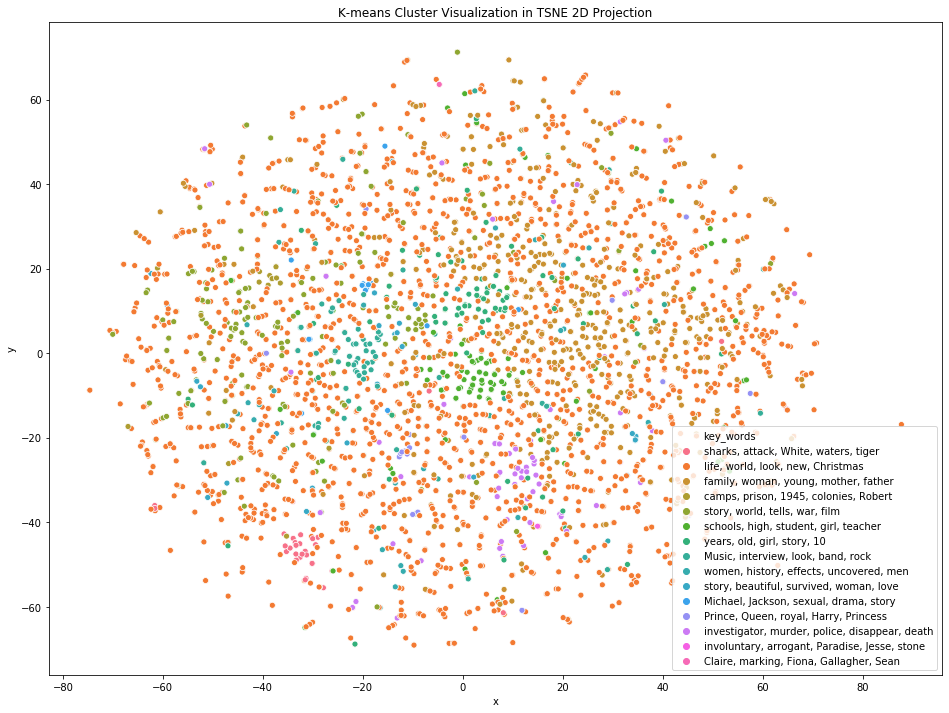

In [24]:
# get 2-D representation of our data
X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())

# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
df_tsne['cluster'] = df_clusters['cluster'].copy().values
df_tsne['key_words'] = df_tsne.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=df_tsne,
    ax=ax
)

**Obervations about LSA + k-means clustering**
1. LSA + k-means seems to be able to catch more non-linearity in the features space
2. the clusters are occuppying larger space

### Topic Modeling - LDA (Latent Dirichlet allocation)

1. vectorize docs using Count vectorizer
2. check the number of samples per group to confirm we have balanced samples accross different topics
3. calculate votes aggregate stats (eg. mean, ...) group by topic to check whether there are regression signals
4. print top n frequent words in each topic's distribution and some movies' titles to verify whether the grouping actually makes sense
5. use T-SNE to visualize LDA topic modeling effect

**1. vectorize docs using Count vectorizer**

In [25]:
# get bag of words matrix
tf_vectorizer = CountVectorizer(
    min_df=2, # words with low document frequency usually are rare words like person's name, or rare entity name
    max_df=0.95, # words with high document frequency usually are common words like 'is', 'are', 'yes', 'what', ..
    max_features=10000, # we only include top 10000 words with highest tf-idf weights
    stop_words='english',
    tokenizer=tokenization_and_stemming, # our customized tokenizer
    ngram_range=(1,1) # not considering bi-gram
)

# get tf-idf features
tf_matrix = tf_vectorizer.fit_transform(data['plot'])
# get all selected words
tf_selected_words = tf_vectorizer.get_feature_names()
# print
tf_matrix.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(3167, 6406)

**2. check the number of samples per group to confirm we have balanced samples accross different topics**

In [34]:
# train LDA model
n_topics = 15
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='online',
    learning_offset=50,
    n_jobs=-1,
    random_state=99).fit(tf_matrix)
# reduce dimension of tf_matrix to n_topics
lda_matrix = lda.transform(tf_matrix)

In [36]:
# create DataFrame df_topics for topic analysis
topics = np.argsort(lda_matrix, axis=1)[:, ::-1][:, 0]

# create DataFrame df_clusters for clustering analysis
data_topics = {
    'title': data.title.values,
    'plot': data['plot'].values,
    'run time': data['run time /min'].values,
    'votes': data['number of votes'].values,
    'rating':data.rating.values,
    'topic': np.argsort(lda_matrix, axis=1)[:, ::-1][:, 0]
}
df_topics = pd.DataFrame(
    data_topics,
    index=[topics],
    columns=['title','plot','run time', 'votes','rating', 'topic']
)

df_topics.head(3)

,title,plot,run time,votes,rating,topic
8,Sharknado,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3,8
1,The Normal Heart,A gay activist attempts to raise H.I.V. and A....,132,31793,7.9,1
1,The Sunset Limited,"Through a chance encounter, two men of opposin...",91,26733,7.4,1


**3. calculate votes aggregate stats (eg. mean, ...) group by topic to check whether there are regression signals**

In [37]:
print("High level aggregate statistics of 'votes' for each topic:")
df_topics.groupby('topic')['votes'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'votes' for each topic:


,mean,median,max,min,count
topic,,,,,
1,526.831897,55.0,31793,9,928
2,1031.495413,372.0,17067,10,109
3,5163.142857,1673.0,19471,34,7
4,1258.409639,386.0,12123,9,83
5,6847.571429,3548.0,25551,283,7
6,5966.571429,4489.0,14353,97,7
7,737.142857,32.0,4833,11,7
8,7443.500000,2001.5,44265,105,8
9,3023.916667,2042.0,8114,20,12


**4. print top n frequent words in each topic's distribution and some movies' titles to verify whether the grouping actually makes sense**

In [41]:
# let take top n words
topn = 5
# get word distribions for each topic
topic_word_distribution = lda.components_
# get sorted word index for each topic (most important words ranked earlier)
sorted_idx_topics = np.argsort(topic_word_distribution, axis=1)[:, ::-1]
# init topic_keywords for storing key words
topic_keywords = {}

print("<Movie plot summaries clustering result by K-means>")
for i in df_topics.topic.sort_values().unique():
    print('Topic', i)
    print('num movies:', len(df_topics.loc[i]))
    print('average votes:', round(df_topics.loc[i, 'votes'].mean(), 2))
    print('key words:')
    # record key words for each topic
    topic_keywords[i] = [stem_to_word_dict[tf_selected_words[idx]] for idx in sorted_idx_topics[i, :topn]]
    print(topic_keywords[i])
    print('sample titles:')
    print(df_topics.loc[i]['title'].sample(n=1, replace=False).values.tolist())
    print()

<Movie plot summaries clustering result by K-means>
Topic 1
num movies: 928
average votes: 526.83
key words:
['story', 'world', 'film', 'documentary', 'life']
sample titles:
['Jodi Arias: Dirty Little Secret']

Topic 2
num movies: 109
average votes: 1031.5
key words:
['King', 'Prince', 'Queen', 'Princess', 'royal']
sample titles:
['Porn on the Brain']

Topic 3
num movies: 7
average votes: 5163.14
key words:
['Barry', 'cancer', 'Timmy', 'fraud', 'upcoming']
sample titles:
['Call Me Crazy: A Five Film']

Topic 4
num movies: 83
average votes: 1258.41
key words:
['murder', 'investigator', 'police', 'killers', 'detection']
sample titles:
['Jesse Stone: Lost in Paradise']

Topic 5
num movies: 7
average votes: 6847.57
key words:
['Michael', 'Jackson', 'polish', 'Poland', 'Marcel']
sample titles:
['Mo']

Topic 6
num movies: 7
average votes: 5966.57
key words:
['Anaïs', 'Whitney', 'Putin', 'doping', 'chronicles']
sample titles:
['I, Putin: A Portrait']

Topic 7
num movies: 7
average votes: 737.

In [42]:
topic_keywords

{1: ['story', 'world', 'film', 'documentary', 'life'],
 2: ['King', 'Prince', 'Queen', 'Princess', 'royal'],
 3: ['Barry', 'cancer', 'Timmy', 'fraud', 'upcoming'],
 4: ['murder', 'investigator', 'police', 'killers', 'detection'],
 5: ['Michael', 'Jackson', 'polish', 'Poland', 'Marcel'],
 6: ['Anaïs', 'Whitney', 'Putin', 'doping', 'chronicles'],
 7: ['eines', 'und', 'kidnapper', 'den', 'der'],
 8: ['Angeles', 'Los', 'Hop', 'Vincent', 'erupted'],
 9: ['Joe', 'Karen', 'scandals', 'Sandy', 'student'],
 10: ['minister', 'Churchill', 'prime', 'Greta', 'Dave'],
 11: ['chefs', 'restaurant', 'Donald', 'cook', 'Trump'],
 12: ['Lucas', 'Bruce', 'Lee', 'Nathan', 'Inge'],
 13: ['Jack', 'schools', 'teenager', 'Louis', 'dad'],
 14: ['family', 'life', 'years', 'love', 'young']}

**Obervations about the claps vs. LDA topics**
1. LDA topic clustering seems to yeild a more sensible clustering result than using K-Means based on the key words and blog post's titles
2. Both LDA and K-means methods like group of ['people', 'make', 'times', 'work', 'like'], dislike group of ['com', 'https', 'www', 'Social', 'Media']
3. In general, readers prefer trendy topic like blockchain, Entrepreneurship, ..

**5. use T-SNE to visualize LDA topic modeling effect**

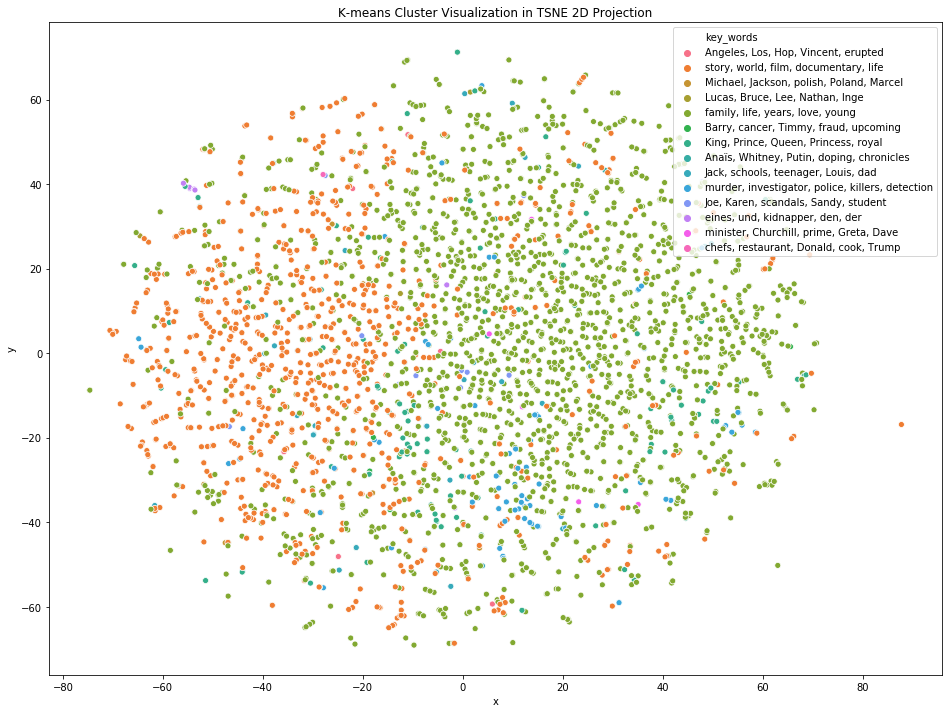

In [44]:
# get 2-D representation of our data
X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())

# convert to dataframe for visualization
data_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
data_tsne['topic'] = df_topics['topic'].copy().values
data_tsne['key_words'] = data_tsne['topic'].map(topic_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=data_tsne,
    ax=ax
)

### Sementic indexing

In [45]:
# get similarity matrix using lda matrix
sim_matrix = cosine_similarity(lda_matrix)
# get the one with most votes
movie_idx = data[data['number of votes'] == data['number of votes'].max()].index[0]
# query the top 10 most similar movies
data.loc[np.argsort(sim_matrix[movie_idx])[::-1][:10]]

,title,release year,genre,key words,plot,run time /min,number of votes,rating
0,Sharknado,2013,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,school-bus|chainsaw|psychotronic-film|hurrican...,"When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3
179,Lavalantula,2015,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,giant-spider|family-man|tremor|shaker|shotgun|...,Volcanic eruptions in Los Angeles unleash a sw...,83,2506,4.6
323,The Five(ish) Doctors Reboot,2013,Comedy|Drama,doctor-who|actor-playing-himself|actor|actor-w...,With the 50th anniversary of Doctor Who (1963)...,30,1568,8.6
241,Painted with Words,2010,Documentary|Biography,vincent-van-gogh-character|theo-van-gogh-chata...,"The story of Vincent Van Gogh, with dialogue s...",80,1955,8.0
57,Descendants 2,2017,Action|Adventure|Family|Fantasy|Romance,fairy-godmother-character|the-beast-character|...,"Mal, Evie, Carlos and Jay try to adjust to lif...",111,6519,6.5
1737,Who Shot Biggie & Tupac?,2017,Documentary,reenactment,A look into the unsolved murders of the 90s hi...,84,105,6.4
805,SnakeHead Swamp,2014,Action|Adventure|Comedy|Horror|Sci-Fi|Thriller,psychotronic-film|snakehead-fish|louisiana|fis...,Terror strikes when a swarm of Snakehead fish ...,86,582,3.1
231,CrazySexyCool: The TLC Story,2013,Biography|Drama|Music,woman,The story of Legendary hip hop/r&b/pop trio TLC.,105,2048,7.6
50,Fred: The Movie,2010,Adventure|Comedy|Family|Romance,latex-gloves|in-love|suspenders|sand|crush|mov...,"Lovestruck, awkward teen Fred Figglehorn makes...",81,7016,1.9
1475,Inferno: The Making of 'The Expendables',2010,Documentary,making-of|greco-roman-wrestling|thriller-filmm...,"The making of ""The Expendables"" directed by Sy...",88,170,7.8
